<h1 style="font-size:30px;">Image Inpainting for Image Restoration</h1>

In this module we will describe a class of *region filling algorithms* called **image inpainting**.

Imagine finding an old family photograph. You scan it and it looks great, except for a few scratches. Of course, you could always load the photo in Photoshop to fix the scratches. Instead, in this notebook we will leverage OpenCV to fix the image.

# 1. What is Image Inpainting?

Image inpainting is a class of algorithms in computer vision where the objective is to fill regions inside an image or a video in a way that it fits the context of its surroundings.

The region is identified using a binary mask, and the filling is usually done by propagating information from the boundary of the region that needs to be filled.

A common application of image inpainting is the restoration of old scanned photos. It is also used for removing small unwanted objects in an image.

# 2. Inpainting Algorithms

In this section, we will briefly discuss two inpainting algorithms implemented in OpenCV.

## 2.1 Navier-Stokes & Fast Marching
### <font style="color:rgb(50,120,230)">INPAINT_NS : Navier-Stokes based Inpainting</font>
    
This method was published in 2001 in a paper titled ["Navier-Stokes, Fluid Dynamics, and Image and Video Inpainting"](http://www.math.ucla.edu/~bertozzi/papers/cvpr01.pdf).

This paper shows off how the field of Computer Vision is a melting pot of different disciplines, pulling concepts from fields like electrical engineering, computer science, physics, and mathematics. They bring their ideas to the field and solve the same problem in very interesting and unique ways. An electrical engineer may see an image as a 2D signal and apply the theories of signal processing to solve computer vision problems. On the other hand, a mathematician may see an image as a connected graph and solve computer vision problems using graph theory.

So it isn’t surprising that theories developed for fluid dynamics also make their way into computer vision.

In the image below, our objective is to fill the dark region and obtain an image that looks like the one on the right.

<br>
<center>
<img src="https://www.learnopencv.com/wp-content/uploads/2019/04/image-inpainting-example.jpg" alt="/image-inpainting-example.jpg">
</center>
<br>

How do we fill this black region? One constraint we would like is the edge entering point A should continue to the edge leaving point B. The other constraint we may want is that the region on the right of the curve joining A and B should be white, and the region on the left should be blue.

The above two constraints can be summarized as:

1. Preserve gradients (i.e. edge-like features)
2. Continue to propagate color information in smooth regions

The authors set up a partial differential equation (PDE) to update image intensities inside the region with the above constraints.

The image smoothness information is estimated by the image Laplacian and it is propagated along the isophotes (contours of equal intensities). The isophotes are estimated by the image gradient rotated by 90 degrees.

The authors show that these equations are closely related in form to the Navier-Stokes equations for 2D incompressible fluids.

The benefit of reframing the problem in the field of fluid dynamics, is that we benefit from well developed theoretical analysis and numerical tools.

### <font style="color:rgb(50,120,230)">INPAINT_TELEA : Fast Marching Method based</font>

This implementation is based on a paper titled ["An Image Inpainting Technique Based on the Fast Marching Method"](https://pdfs.semanticscholar.org/622d/5f432e515da69f8f220fb92b17c8426d0427.pdf) by Alexandru Telea.

This implementation solves the same constraints using a different technique. Instead of using the image Laplacian as the estimator of smoothness, the author uses a weighted average over a known image neighborhood of the pixel to inpaint. The known neighborhood pixels and gradients are used to estimate the color of the pixel to be inpainted.

Once a pixel is inpainted, the boundary needs to be updated. The author treats the missing region of the image as [level sets](https://en.wikipedia.org/wiki/Level_set) and uses the [fast marching method](https://en.wikipedia.org/wiki/Fast_marching_method) to update the boundary.

## 2.2 Pros and Cons

As per the theory and the papers, Navier-Stokes based inpainting is supposed to be slower and has a tendency to produce results that are blurrier than the Fast Marching based method.

In practice though, the performance may vary depending on the image.

## 2.3 Inpainting Code in Python

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font style = "color:rgb(8,133,37)">Function Syntax</font>
    
In OpenCV inpainting is implemented using the function `inpaint`.

```python
dst = cv2.inpaint(src, inpaintMask, inpaintRadius, flags)
```

Where,

- **`src`**: Source image
- **`inpaintMask`**: A binary mask indicating pixels to be inpainted.
- **`dst`**: Destination image
- **`inpaintRadius`**: Neighborhood around a pixel to inpaint. Typically, if the regions to be inpainted are thin, smaller values produce better results (less blurry).
- **`flags`**: `INPAINT_NS` (Navier-Stokes based method) or `INPAINT_TELEA` (Fast marching based method)

### <font color="green">OpenCV Documentation</font>


[**`inpaint()`**](https://docs.opencv.org/4.5.3/d7/d8b/group__photo__inpaint.html)

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

# 3. Sample implementation

Below, we will create an interactive demo which can run either of these two inpainting algorithms.

In [8]:
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt

if 'google.colab' in str(get_ipython()):
    print("Downloading Code to Colab Environment")
    !wget https://www.dropbox.com/sh/btghqk0xvgeypl1/AAD9K7FQ_s0j3Dw-4K-JPjdya?dl=1 -O module-code.zip -q --show-progress
    !unzip -qq module-code.zip
else:
    pass

In [9]:
class Sketcher:
    """OpenCV Utility class for mouse handling."""

    def __init__(self, windowname, dests, colors_func):
        self.prev_pt = None
        self.windowname = windowname
        self.dests = dests
        self.colors_func = colors_func
        self.dirty = False
        self.show()
        cv2.setMouseCallback(self.windowname, self.on_mouse)

    def show(self):
        cv2.imshow(self.windowname, self.dests[0])
        cv2.imshow(self.windowname + ": mask", self.dests[1])

    def on_mouse(self, event, x, y, flags, param):
        """Hanles mouse movement and events."""
        pt = (x, y)
        if event == cv2.EVENT_LBUTTONDOWN:
            self.prev_pt = pt
        elif event == cv2.EVENT_LBUTTONUP:
            self.prev_pt = None

        if self.prev_pt and flags & cv2.EVENT_FLAG_LBUTTON:
            for dst, color in zip(self.dests, self.colors_func()):
                cv2.line(dst, self.prev_pt, pt, color, 5)
            self.dirty = True
            self.prev_pt = pt
            self.show()

In [10]:
# Read image in color mode.
filename = "images/Car.jpg"
img = cv2.imread(filename, cv2.IMREAD_COLOR)

# If image is not read properly, return error.
if img is None:
    print('Failed to load image file: {}'.format(filename))

In [11]:
# Create a copy of original image.
img_mask = img.copy()
# Create a black copy of original image, acts as a mask.
inpaintMask = np.zeros(img.shape[:2], np.uint8)
# Create sketch using OpenCV Utility Class: Sketcher.
sketch = Sketcher('image', [img_mask, inpaintMask], lambda : ((0, 255, 0), 255))

In [12]:
while True:
    ch = cv2.waitKey()
    if ch == 27:
        break
    if ch == ord('t'):
        # Use Algorithm proposed by Alexendra Telea: Fast Marching Method (2004).
        t1t = time.time()
        res = cv2.inpaint(src=img_mask, inpaintMask=inpaintMask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
        t2t = time.time()
        ttime = t2t-t1t
        cv2.imshow('Inpaint Output using FMM', res)
    if ch == ord('n'):
        # Navier-Stokes, Fluid Dynamics, and Image and Video Inpainting (2001).
        t1n = time.time()
        res = cv2.inpaint(src = img_mask, inpaintMask = inpaintMask, inpaintRadius=3, flags=cv2.INPAINT_NS)
        t2n = time.time()
        ntime = t2n-t1n
        cv2.imshow('Inpaint Output using NS Technique', res)
    if ch == ord('r'):
        img_mask[:] = img
        inpaintMask[:] = 0
        sketch.show()

In [13]:
cv2.destroyAllWindows()

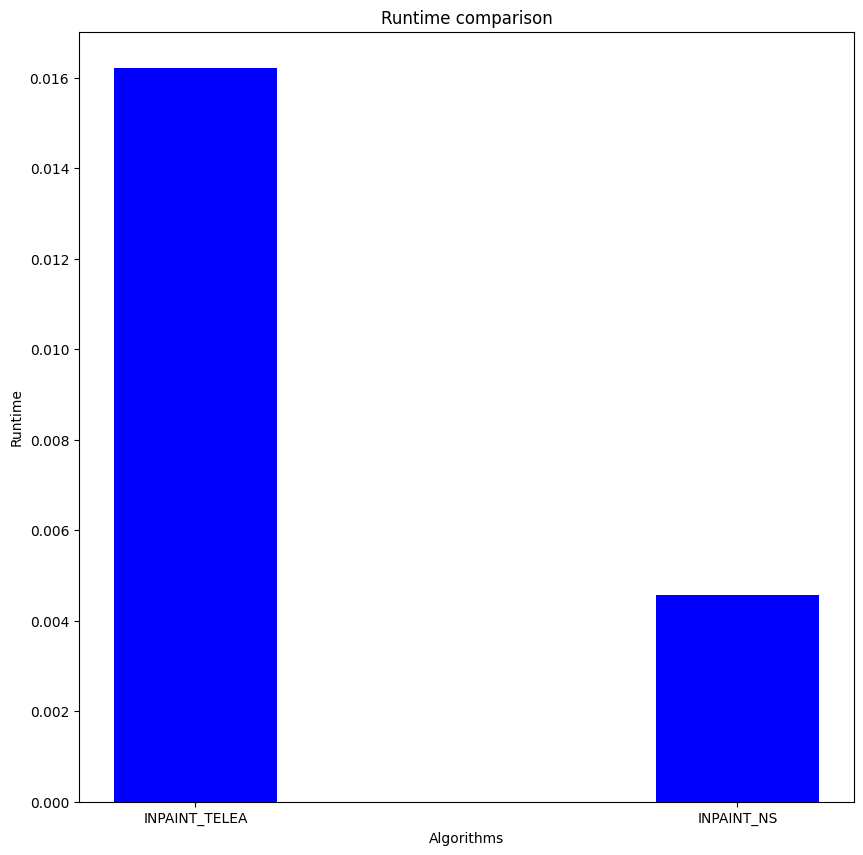

In [14]:
times = [ttime, ntime]
methods = ['INPAINT_TELEA', 'INPAINT_NS']

# Plot size
fig = plt.figure(figsize = (10, 10))
 
# Creating the stacked bar plot
plt.bar(methods, times, color ='blue', width = 0.3)
 
plt.xlabel('Algorithms')
plt.ylabel('Runtime')
plt.title('Runtime comparison')
plt.show()

# 4. Inpainting Results</font>
Let’s look at the result of applying inpainting to some old images that have given the test of time.

| ![c0-m10-inpaint-output1.jpg](https://opencv.org/wp-content/uploads/2021/09/c0-m10-inPaint-output1.jpg) |
| --- |
| <center>Inpainting Results : The first image (top-left) is the input image, the second image (top-right) is the mask, the third image (bottom-left) is the result of INPAINT_TELEA and the last image (bottom-right) is by INPAINT_NS.</center> |

<br><br>

| ![c0-m10-inpaint-output2.jpg](https://opencv.org/wp-content/uploads/2021/09/c0-m10-inPaint-output2.jpg) |
| --- |
| <center>Inpainting Results : The first image (top-left) is the input image, the second image (top-right) is the mask, the third image (bottom-left) is the result of INPAINT_TELEA and the last image (bottom-right) is by INPAINT_NS.</center> |